# *AIML CA1 PART B: REGRESSION*

*Qn. How is your prediction task defined? And what is the meaning of theoutput variable?*

The task is to build a regression model to predict the housing price based on various factors. As we want to find the price, it will be taken as the target variable.

The remainder columns such as number of bedrooms, toilets, etc will be taken as features that we will take into consideration for the model to predit the house price.

In [31]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score,learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score,make_scorer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor


In [32]:
data = pd.read_csv('housing_dataset.csv', index_col=0)

*Qn. How do you represent your data as features?*

In [33]:
data.head()

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
House ID,,,,,,,
0,Chicago,742.0,4,2,3,furnished,1330000
1,Denver,896.0,4,4,4,furnished,1225000
2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,Seattle,750.0,4,2,2,furnished,1221500
4,New York,742.0,4,1,2,furnished,1141000


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               545 non-null    object 
 1   House Area (sqm)   545 non-null    float64
 2   No. of Bedrooms    545 non-null    int64  
 3   No. of Toilets     545 non-null    int64  
 4   Stories            545 non-null    int64  
 5   Renovation Status  545 non-null    object 
 6   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 34.1+ KB


In [35]:
data.describe()

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($)
count,545.000000,545.000000,545.000000,545.000000,5.450000e+02
mean,515.054128,2.965138,1.286239,1.805505,4.766729e+05
std,217.014102,0.738064,0.502470,0.867492,1.870440e+05
min,165.000000,1.000000,1.000000,1.000000,1.750000e+05
25%,360.000000,2.000000,1.000000,1.000000,3.430000e+05
50%,460.000000,3.000000,1.000000,2.000000,4.340000e+05
75%,636.000000,3.000000,2.000000,2.000000,5.740000e+05
max,1620.000000,6.000000,4.000000,4.000000,1.330000e+06


After taking a look at some of the data as well as its statistics, we know that we will not need to drop any rows which has been affected by null values.

We will take a more indepth look at the distribution of the data.

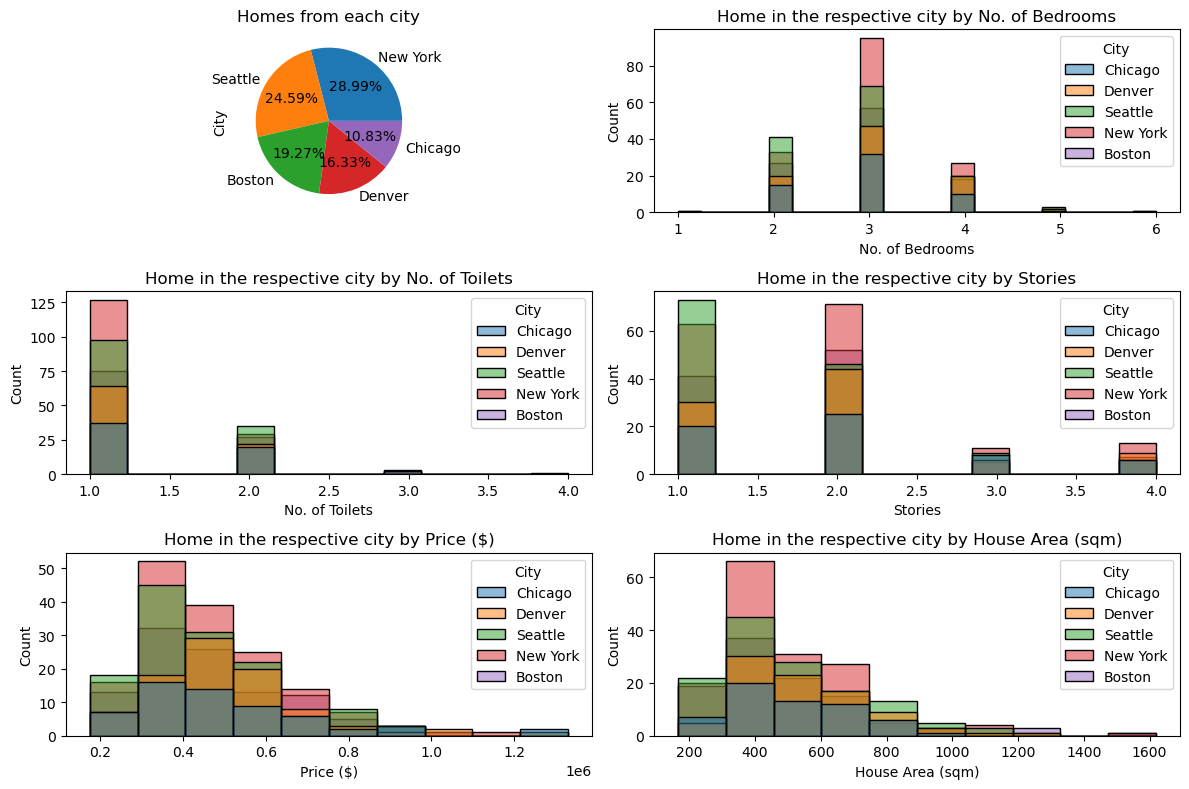

In [36]:
fig, axes = plt.subplots(3,2 , figsize=(12, 8))

data['City'].value_counts().plot(kind = 'pie',autopct = '%1.2f%%', ax=axes[0,0])
axes[0,0].set_title('Homes from each city')

sns.histplot(data=data, x='No. of Bedrooms', hue='City', ax=axes[0, 1])
axes[0, 1].set_title('Home in the respective city by No. of Bedrooms')

sns.histplot(data=data, x='No. of Toilets', hue='City', ax=axes[1, 0])
axes[1, 0].set_title('Home in the respective city by No. of Toilets')

sns.histplot(data=data, x='Stories', hue='City', ax=axes[1, 1])
axes[1, 1].set_title('Home in the respective city by Stories')

sns.histplot(data=data, x='Price ($)', hue='City', bins = 10, ax=axes[2, 0])
axes[2,0].set_title('Home in the respective city by Price ($)')

sns.histplot(data=data, x='House Area (sqm)', hue='City', bins=10, ax=axes[2,1])
axes[2,1].set_title('Home in the respective city by House Area (sqm)')


plt.tight_layout()
plt.show()

As we can see, the data set provided is decently balanced out with the highest percentage, New York, taking up 28.99% of the data. Whereas the lowest is 10.83% in Chicago.

Number of bedrooms seem to be more normally distributed, with 3 being the median.

Number of toilets as well as number of stories have shown little pattern in its distribution.

Price and house area seem to be skewed to the right and show very similar graphs. This could mean that there is a possible correlation between the 2 features.

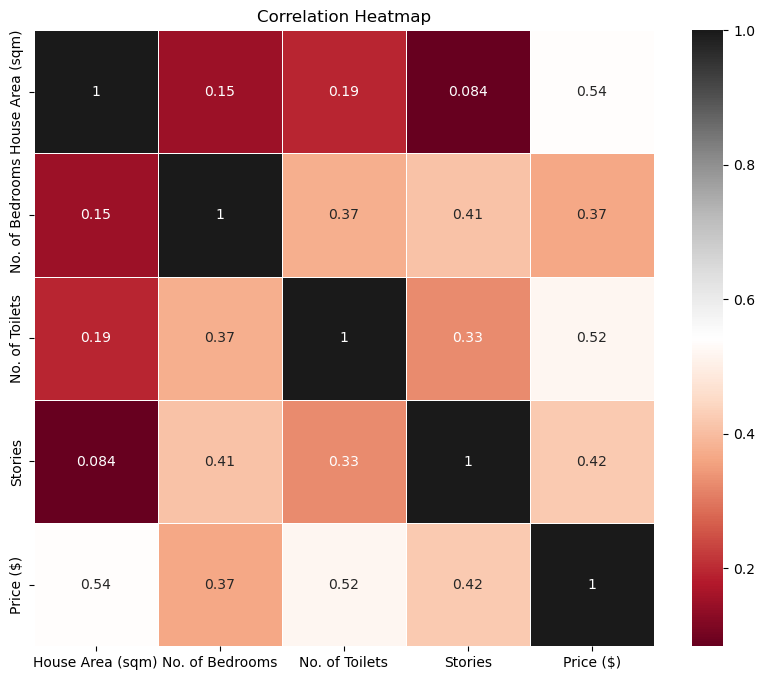

In [37]:
# Computing the correlation matrix
corr_matrix = data.corr()

# Creating a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdGy', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

From the correlation above, we can see that there is a moderate correlation between house area and price as well as number of toilets and price. This shows that these two features could be more significant than the rest of the features.

*Qn. Did you process the features in any way?*

Now, in order to start applying the data to our model, we need to encode the categorical data so that the machine can process the numerical data.

In addidtion, I engineered a new column which calculated the cost of the area. This is important as it helps to take into account the possible price of land as we are not finding the price of the houses in 1 specific area only.

In [38]:
# Feature engineering
data['Price/sqm'] = data["Price ($)"] / data['House Area (sqm)']

# Perform one-hot encoding
dummies = pd.get_dummies(data[["City", "Renovation Status"]], drop_first=True)

# Concatenate the original data with the encoded dummies
data_enc = pd.concat([data, dummies], axis=1)

# Create a subset to be dropped
to_drop = ["City", "Renovation Status"]

#Drop the data for feature selection
data_enc = data_enc.drop(to_drop, axis = 1)

In [39]:
data_enc.head()

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),Price/sqm,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_semi-furnished,Renovation Status_unfurnished
House ID,,,,,,,,,,,,
0,742.0,4,2,3,1330000,1792.452830,1,0,0,0,0,0
1,896.0,4,4,4,1225000,1367.187500,0,1,0,0,0,0
2,996.0,3,2,2,1225000,1229.919679,1,0,0,0,1,0
3,750.0,4,2,2,1221500,1628.666667,0,0,0,1,0,0
4,742.0,4,1,2,1141000,1537.735849,0,0,1,0,0,0


In [40]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Calculate mean and standard deviation of training scores
    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Calculate mean and standard deviation of test scores
    test_mean = -np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training MSE')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Cross Validation MSE')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
    
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


This is a simple function that will plot out the learning curve of the model.

In [41]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Fit the model to the training data
    model.fit(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Predicted values
    print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))  
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_pred, y_test)
    print("Mean Squared Error (MSE):", mse)
    
    # Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    print("Root Mean Squared Error (RMSE):", rmse)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_pred, y_test)
    print("Mean Absolute Error (MAE):", mae)
    
    # R-squared (R2) score
    r2 = r2_score(y_pred, y_test)
    print("R-squared (R2) score:", r2)
    
    # Explained Variance Score
    explained_variance = explained_variance_score(y_pred, y_test)
    print("Explained Variance Score:", explained_variance)

    plot_learning_curve(model, x_train, y_train)
 
    test = pd.DataFrame({'Predicted value':y_test, 'Actual value':y_pred})
    fig= plt.figure(figsize=(16,8))
    test = test.reset_index()
    test = test.drop(['index'],axis=1)
    plt.plot(test)
    plt.legend(['Actual value','Predicted value'])

*Qn. How do you evaluate the quality of your system?*

This simple function prints out the respective evaluation methods as well as the learning curve function i made earlier.

The evaluation methods include :
- Mean Squared Error (MSE)              >> The lower the better
- Root Mean Squared Error (RMSE)        >> The lower the better
- Mean Absolute Error (MAE)             >> The lower the better
- R-Squared (R2)                        >> Range of 0-1, The higher the better the model fits the data
- Explained variance of the model       >> Range of 0-1, The closer to 1, the better it explains the variance of the model

We will be using RMSE as the main evaluation as it provoides the value difference on average which allows us to guage how different the model would be


In [42]:
x = pd.DataFrame(data_enc.drop("Price ($)", axis=1).values, columns=data_enc.drop("Price ($)", axis=1).columns)
y = data_enc['Price ($)'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

Predictions: [476695.18348624 476695.18348624], Actual Values: [420000 364000]
Mean Squared Error (MSE): 30072943085.771313
Root Mean Squared Error (RMSE): 173415.52146728768
Mean Absolute Error (MAE): 127739.10201161519
R-squared (R2) score: -2.2189915385858264e+30
Explained Variance Score: -2.2189906246411164e+30


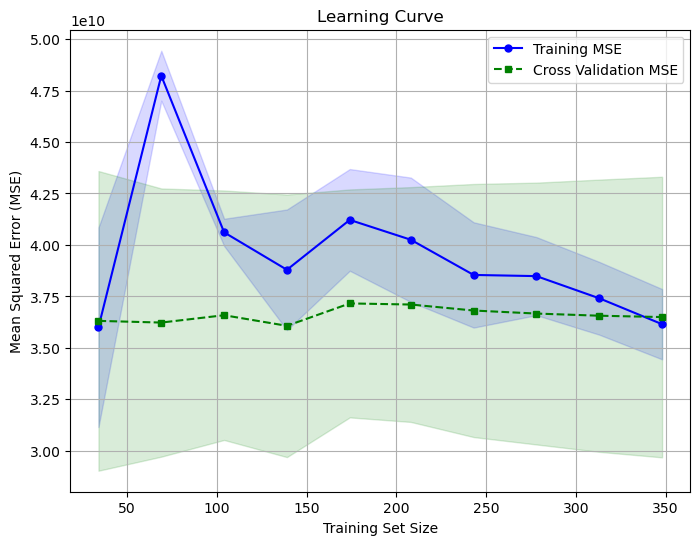

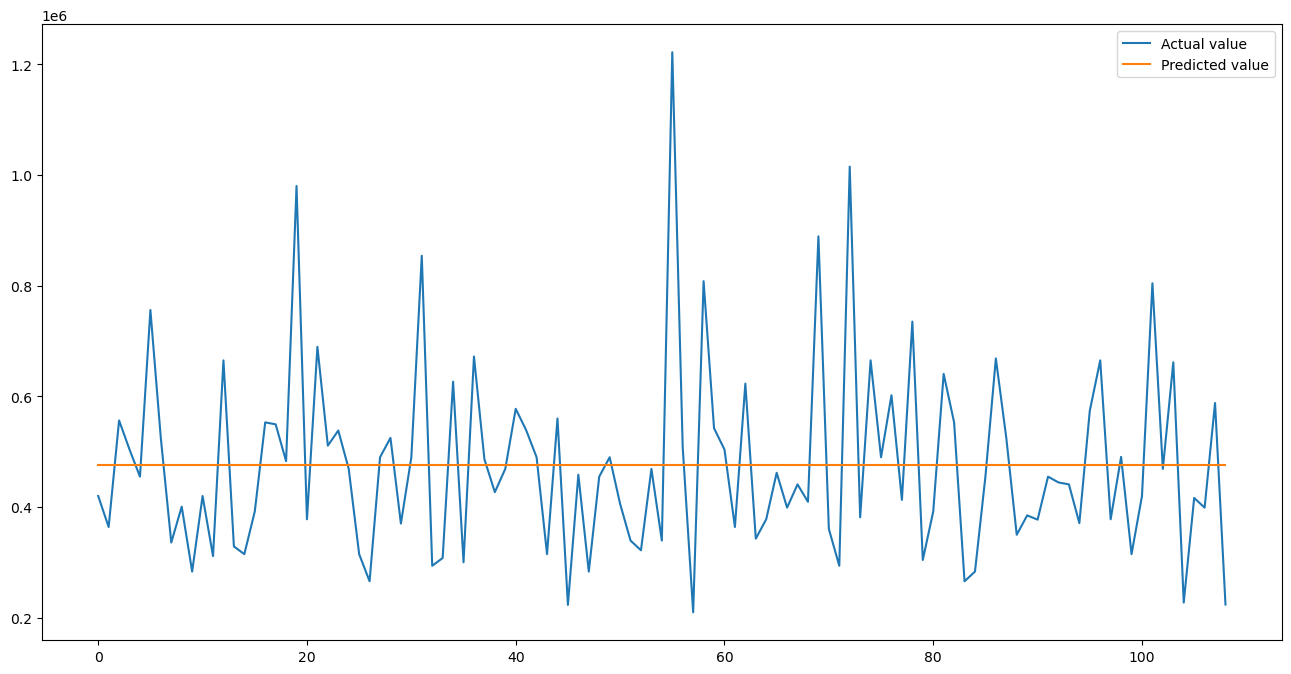

In [43]:
baseline_model = Pipeline([
                ('Model', DummyRegressor(strategy='mean'))  
])

evaluate_model(baseline_model, x_train, y_train, x_test, y_test)

*Qn. How did you select which learning algorithms to use?*

With no particular characteristic that stands out in the dataset (eg. imbalanced data), I will be testing a few models based on their RMSE

In [44]:
regressors = {
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "LinearSVR": LinearSVR(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge()
}

df_models = pd.DataFrame(columns=['model', 'rmse', 'rmse_cv'])

for key in regressors:

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores = cross_val_score(model, 
                             x_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'rmse_cv': round(np.mean(np.sqrt(-scores)))
    }

    df_models = df_models.append(row, ignore_index=True)

    df_models.head(20).sort_values(by='rmse_cv', ascending=True)

C:\Users\3mm3t\AppData\Local\Temp\ipykernel_1892\3590714018.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\3mm3t\AppData\Local\Temp\ipykernel_1892\3590714018.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\3mm3t\AppData\Local\Temp\ipykernel_1892\3590714018.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\3mm3t\AppData\Local\Temp\ipykernel_1892\3590714018.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row,

In [45]:
df_models.head(20).sort_values(by='rmse_cv', ascending=True)

,model,rmse,rmse_cv
0,RandomForestRegressor,29867,40555
1,DecisionTreeRegressor,36216,54860
6,Ridge,71537,79135
5,LinearRegression,71612,79205
7,Lars,71612,79567
8,ARDRegression,73282,81918
9,BayesianRidge,70719,81919
4,LinearSVR,110137,110900
3,SVR,179424,192074
2,GaussianProcessRegressor,506150,508865


Predictions: [394135.35 372701.  ], Actual Values: [420000 364000]
Mean Squared Error (MSE): 882723103.1056881
Root Mean Squared Error (RMSE): 29710.656389680928
Mean Absolute Error (MAE): 18555.022018348624
R-squared (R2) score: 0.964624282641405
Explained Variance Score: 0.9651178397630119


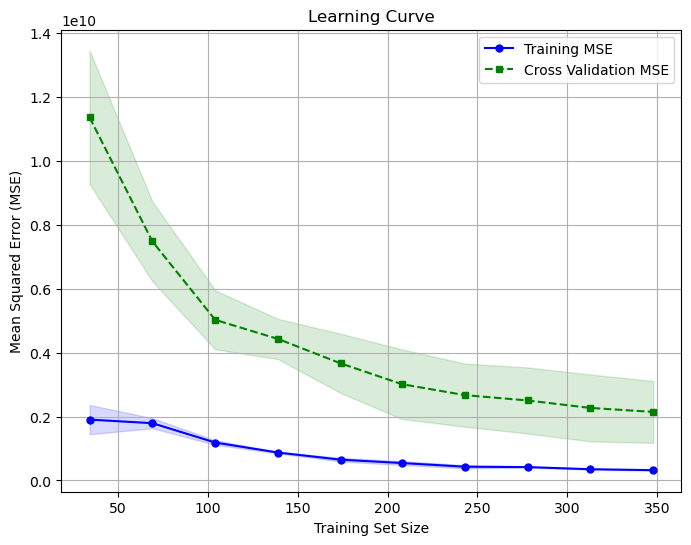

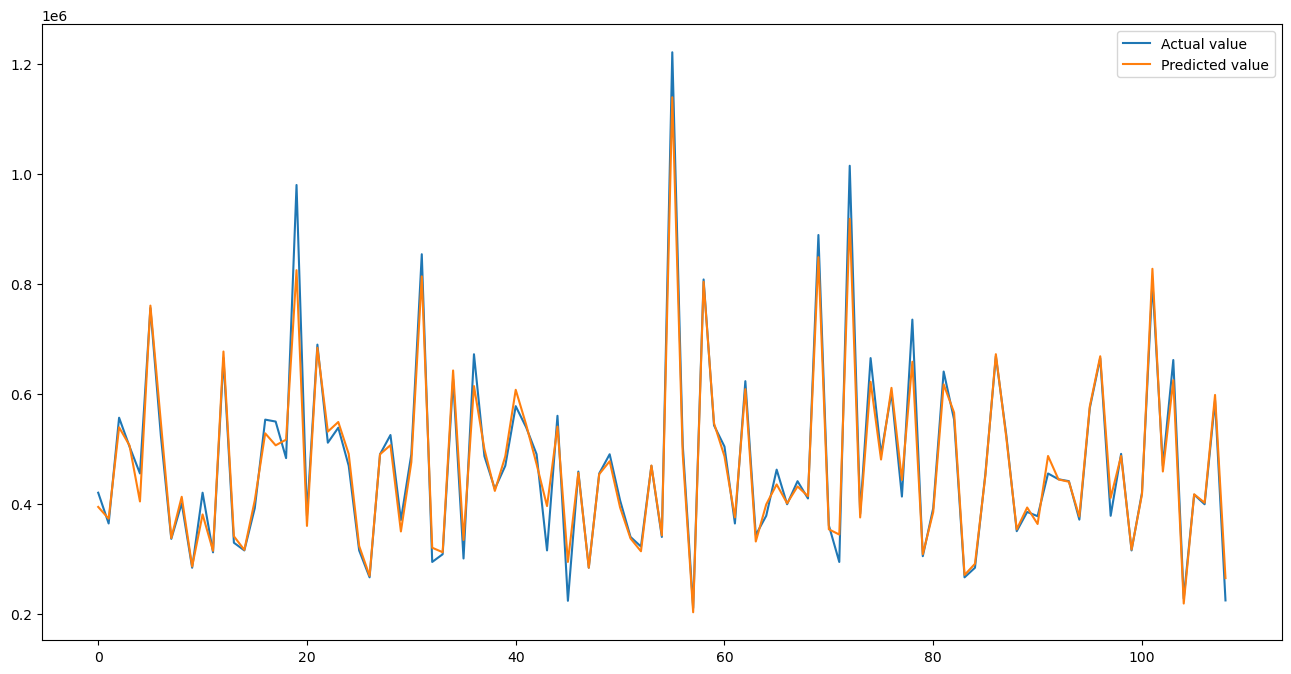

In [46]:
RandomForestModel = Pipeline([
                ('Model', RandomForestRegressor())  
])

evaluate_model(RandomForestModel, x_train, y_train, x_test, y_test)

*Qn. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?*

By taking into consideration the different parameters of the Random Forest Regressor,I selected a few values for the random search to do a cross validation through and present the best set of parameters with a scoring method of RMSE

*Qn. How well does your system compare to a dummy baseline?*

Based on the above evaluations, the model performs drastically better as compared to the dummy model.

In [52]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric
RMSE_scoring = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Create an instance of RandomizedSearchCV with RMSE scoring
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring=RMSE_scoring,
    cv=5,
    random_state=42
)

# Fit the RandomizedSearchCV to the data
random_search.fit(x_train, y_train)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)

rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Best Score (RMSE):", rmse)

# Get the best model from the random search
best_model = random_search.best_estimator_


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best Score (RMSE): 30063.9290289117


Predictions: [382781.35694444 374199.43055556], Actual Values: [420000 364000]
Mean Squared Error (MSE): 903839828.6554397
Root Mean Squared Error (RMSE): 30063.9290289117
Mean Absolute Error (MAE): 19147.100807085786
R-squared (R2) score: 0.9636914873542669
Explained Variance Score: 0.9641945359581965


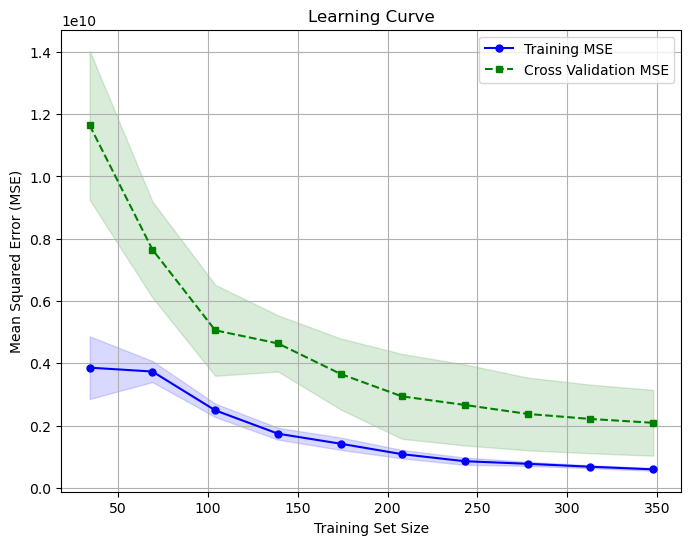

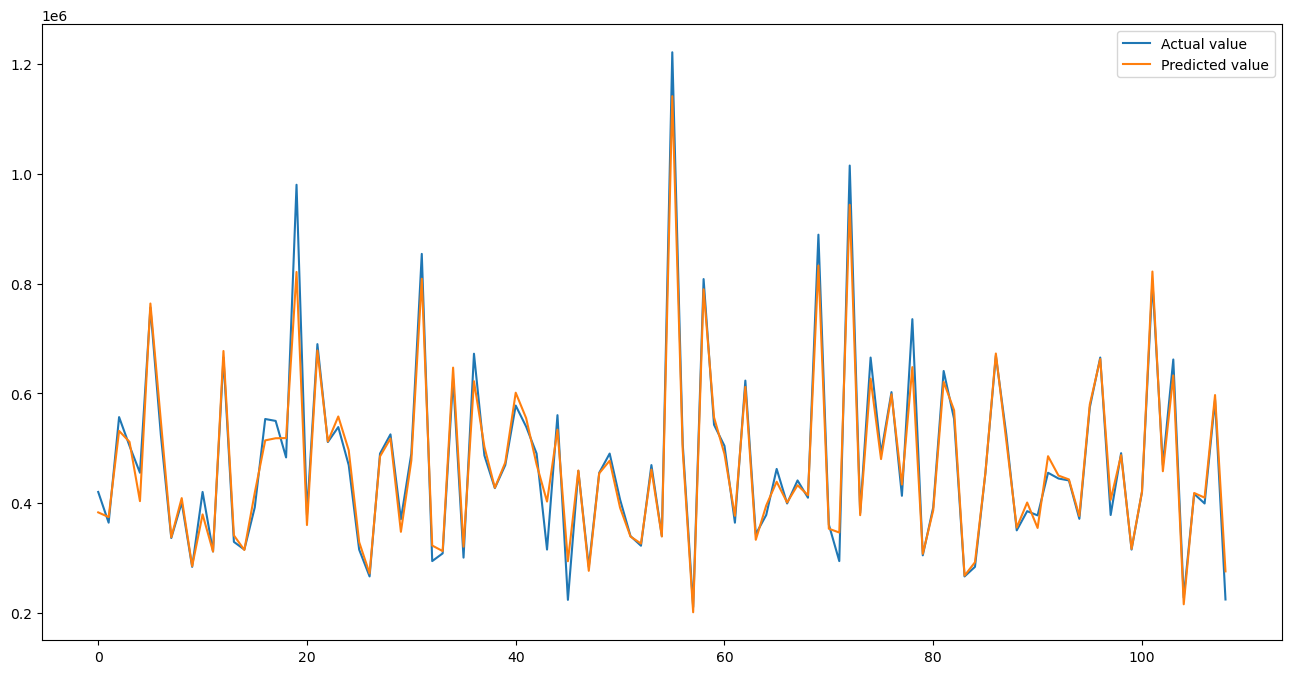

In [48]:
evaluate_model(best_model, x_train, y_train, x_test, y_test)

*Qn. Can you say anything about the errors that the system makes?*

From the graph which compares the predicted values and the actual values, the error made seem to be due to the actual price being very extreme.

   House Area (sqm)  No. of Bedrooms  No. of Toilets   Stories  Price/sqm  \
0          0.554769           0.0019        0.006213  0.001738   0.430263   

   City_Chicago  City_Denver  City_New York  City_Seattle  \
0      0.000482     0.000444       0.000681      0.000764   

   Renovation Status_semi-furnished  Renovation Status_unfurnished  
0                          0.001686                       0.001059  


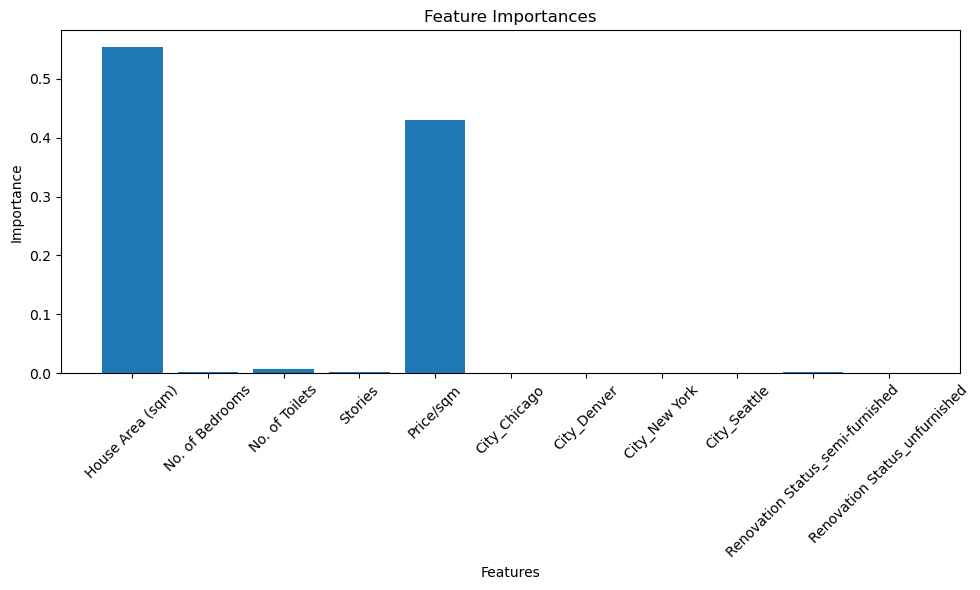

In [49]:
# Get feature importances
importances = pd.DataFrame(best_model.feature_importances_.reshape(1,-1), columns=x.columns)
print(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importances.columns, importances.values.flatten())
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


*Qn. Is it possible to say something about which features the model considers important?*

From the plot of importances, we can see that the model considers House area(sqm) and Price/sqm the most important. They make up about 98% of the data that the model takes into consideration the most. This means that a similar result can be produced with just the two features.